### Les selvsamlede data inn i python

Dette skriptet er et eksempel på hvordan dere kan lese deres egne data inn i python. Datasettet her er hentet inn av Ragnhild Hannaas med samme type logger som det dere bruker, så det skal se nokså likt ut for dere. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Dette er stien til filen du vil laste inn. Bytt den ut med stien til der du har de selvinnhentede dataene dine. 

In [2]:
sti='W:/Work/Documents/EkteData/EkteData/data'
fil='/4-6_januar_Temperaturegistrering_AB-vei.csv'

Forklaring på keywordsene i filinnlesingen under: 
- `sep=','`: kolonnene i csv-filen er skilt med komma. Dette er default for csv-filer, så denne spesifiseringen er strengt tatt overflødig. 
- `header=0`: den første linjen i filen er en "header" altså ikke faktiske data men forklaring på dataene. 
- `engine=python`: siden Celcius en angitt med grad-tegn (special character) må man spesifisere engine. 
- `parse:dates=['Time']`: konverterer kolonnen med tid til "Timestamp" som er lett å jobbe med for tid. 

In [3]:
df=pd.read_csv(
    sti+fil, sep=',', header=0, engine='python',
    parse_dates=['Time']
)

In [4]:
df

,Temp AB-vei,Time,Celsius(°C),Comments,Serial Number
0,1,2022-01-04 15:00:00,4.0,NaN,60039020.0
1,2,2022-01-04 15:01:00,4.0,NaN,NaN
2,3,2022-01-04 15:02:00,4.0,NaN,NaN
3,4,2022-01-04 15:03:00,4.0,NaN,NaN
4,5,2022-01-04 15:04:00,4.0,NaN,NaN
...,...,...,...,...,...
2569,2570,2022-01-06 09:49:00,9.5,NaN,NaN
2570,2571,2022-01-06 09:50:00,10.5,NaN,NaN
2571,2572,2022-01-06 09:51:00,11.0,NaN,NaN
2572,2573,2022-01-06 09:52:00,12.0,NaN,NaN


Konverter pandas DataFramen til et numpy array. Dette tar hånd om tidsaksen bedre når man plotter. 

In [5]:
data=df.to_numpy()

In [6]:
data

array([[1, Timestamp('2022-01-04 15:00:00'), 4.0, nan, 60039020.0],
       [2, Timestamp('2022-01-04 15:01:00'), 4.0, nan, nan],
       [3, Timestamp('2022-01-04 15:02:00'), 4.0, nan, nan],
       ...,
       [2572, Timestamp('2022-01-06 09:51:00'), 11.0, nan, nan],
       [2573, Timestamp('2022-01-06 09:52:00'), 12.0, nan, nan],
       [2574, Timestamp('2022-01-06 09:53:00'), 12.5, nan, nan]],
      dtype=object)

Lagre tidskolonnen og temperaturkolonnen i hver sine vektorer: `tid` og `temp`

In [7]:
tid=data[:,1]
temp=data[:,2]

Lag en figur for å inspisere datasettet. 

(738159.625, 738161.4118055556)

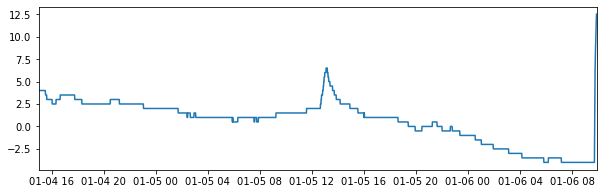

In [8]:
plt.figure(figsize=(10,3))
plt.plot(tid,temp)
plt.xlim(tid[0], tid[-1])

Dette ser litt rart ut - her trenger vi å vite litt om datainnhentingsprosessen for å forstå hva som må forklares av feilkilder og hva som er faktiske temperaturendringer. 

Det er for eksempel to hopp i temperatur: ett etter kl 12 den 5. januar, og ett helt på slutten av tidsserien. Er instrumentet blitt flyttet? Lå instrumentet i skyggen eller i solen? Når man samler inn data er det viktig å holde oversikten over slike forhold som kan påvirke datasettet. 

En annen ting som kan være lurt å sjekke om man bruker et instrument man ikke kjenner til så godt er om den har lagret data med konstant frekvens. I figuren over ser det litt ut som om at noen perioder har høyere oppløsning enn andre. Er det hull i datasettet eller er bare temperaturen veldig jevn i noen perioder?

In [9]:
pd.infer_freq(df['Time'])


'T'